In [ ]:
# MVP Notebook
# Implement User, Ingredient, Recipe, Photo, Recipe Ingredient

# SetUp Connection

In [12]:
import os
import sqlite3
import json
import pandas as pd
import numpy as np

db_file = 'MVPFoodBookExample.db'
if os.path.exists(db_file):
    os.remove(db_file)
    print(f"Removed existing database file: {db_file}")

# Create a database connection (in memory for this exercise)
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Enable foreign key constraint enforcement
cursor.execute("PRAGMA foreign_keys = ON")

print("SQLite version:", sqlite3.sqlite_version)
print("Database connected to:", db_file)

conn.close()

SQLite version: 3.40.1
Database connected to: MVPFoodBookExample.db


# Creating the Tables

In [22]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS Users")
cursor.execute('''
CREATE TABLE Users (
    id INTEGER PRIMARY KEY,
    username TEXT UNIQUE NOT NULL,
    name TEXT,
    email TEXT UNIQUE NOT NULL,
    passwordhash TEXT,
    dietary_preferences TEXT,
    cooking_level INTEGER CHECK ( cooking_level >= 1 and cooking_level <= 5 ),
    allergies TEXT,
    subscription_status TEXT,
    photo_data blob
)
''')
print("User table created successfully")

# Create Ingredient table
cursor.execute("DROP TABLE IF EXISTS Ingredient")
cursor.execute("""
    CREATE TABLE Ingredient (
        id   INTEGER PRIMARY KEY,
        user_id INTEGER NOT NULL,
        name TEXT UNIQUE NOT NULL,
        store TEXT,
        unit TEXT,
        nutritional_label JSON,
        alternative_stores JSON,
        common_substitutes JSON,
        seasonal_availability Text,
        Foreign Key (user_id) references Users(id)
    )
""")
print("Ingredient table created successfully")

# Create Recipe table (each recipe is authored by a user)
cursor.execute("DROP TABLE IF EXISTS Recipe")
cursor.execute("""
    CREATE TABLE Recipe (
        id          INTEGER PRIMARY KEY,
        user_id     INTEGER,
        name TEXT UNIQUE,
        -- CollectionID INTEGER,
        origin TEXT,
        difficulty INTEGER CHECK ( Difficulty >= 1 and Difficulty <= 5 ),
        --Remindertimes Text,
        preparation_steps JSON,
        preparation_time time,
        cooking_time time,
        serving_size INTEGER,
        source TEXT, --_AI_or_self
        photos_json TEXT CHECK (
            json_array_length(photos_json) <= 4
        ),
        FOREIGN KEY(user_id) REFERENCES User(id)
    )
""")
print("Recipe table created successfully")

# # Create Photo table (each photo is uploaded by a user and may be linked to a recipe)
# cursor.execute("DROP TABLE IF EXISTS Photo")
# cursor.execute("""
#     CREATE TABLE Photo (
#         id        INTEGER PRIMARY KEY,
#         user_id   INTEGER,
#         recipe_id INTEGER,
#         file_path TEXT,
#         caption   TEXT,
#         FOREIGN KEY(user_id)   REFERENCES User(id),
#         FOREIGN KEY(recipe_id) REFERENCES Recipe(id)
#     )
# """)
# print("Photo table created successfully")
print('Photo table needs to be thought of')

# Create RecipeIngredient table (join table for Recipe and Ingredient)
cursor.execute("DROP TABLE IF EXISTS RecipeIngredient")
cursor.execute("""
    CREATE TABLE RecipeIngredient (
        recipe_id    INTEGER,
        ingredient_id INTEGER,
        quantity     TEXT,
        unit         TEXT,
        PRIMARY KEY (recipe_id, ingredient_id),
        FOREIGN KEY(recipe_id)    REFERENCES Recipe(id),
        FOREIGN KEY(ingredient_id) REFERENCES Ingredient(id)
    )
""")
print("Recipe ingredient table created successfully")

cursor.execute("DROP TABLE IF EXISTS Meal")
cursor.execute("""
    CREATE TABLE Meal (
        meal_id INTEGER PRIMARY KEY,
        recipe_ids TEXT NOT NULL,  -- JSON array of Recipe IDs, stored as TEXT
        user_id INTEGER NOT NULL,
        meal_time TEXT,  -- E.g., "Breakfast", "Lunch", "Dinner"
        scheduled_datetime TEXT, -- Store datetime as TEXT ("YYYY-MM-DD HH:MM:SS")
        FOREIGN KEY (user_id) REFERENCES Users(user_id)
    );"""
)
print("Meal table created successfully")

cursor.execute("DROP TABLE IF EXISTS MealPlan")
cursor.execute("""
    CREATE TABLE MealPlan (
        meal_plan_id INTEGER PRIMARY KEY,
        title TEXT UNIQUE NOT NULL,
        user_id INTEGER NOT NULL,
        start_date TEXT,  -- Store dates as TEXT (ISO format recommended: "YYYY-MM-DD")
        end_date TEXT,
        FOREIGN KEY (user_id) REFERENCES Users(user_id)
    );
""")
print("Meal plan table created successfully")

cursor.execute("DROP TABLE IF EXISTS MealPlanMeal")
cursor.execute("""
    CREATE TABLE MealPlanMeal (
    meal_plan_id INTEGER NOT NULL,
    meal_id INTEGER NOT NULL,
    PRIMARY KEY (meal_plan_id, meal_id),
    FOREIGN KEY (meal_plan_id) REFERENCES MealPlan(meal_plan_id),
    FOREIGN KEY (meal_id) REFERENCES Meal(meal_id)
);
""")



print("Tables created successfully.")
conn.close()

User table created successfully
Ingredient table created successfully
Recipe table created successfully
Photo table needs to be thought of
Recipe ingredient table created successfully
Meal table created successfully
Meal plan table created successfully
Tables created successfully.


# Populating the database

In [23]:
# Populating the users, ingredients, recipe and recipe_ingredients
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

import sqlite3
import json
import base64
from datetime import datetime

# ---- Insert Users ----
with open('./Sample User Pictures/chef.jpg', 'rb') as file:
    chef_photo = file.read()
with open('./Sample User Pictures/sam.jpg', 'rb') as file:
    sam_photo = file.read()
users = [
    ('chef_alex', 'Alex Gordon', 'alex@example.com', 'hashed_pw_alex', json.dumps(['vegetarian']), 3, 'peanuts', 'active', chef_photo),
    ('baker_emily', 'Emily Stone', 'emily@example.com', 'hashed_pw_emily', json.dumps(['gluten-free']), 5, None, 'free', None),
    ('homecook_sam', 'Sam Lee', 'sam@example.com', 'hashed_pw_sam', json.dumps([]), 2, 'shellfish', 'active', sam_photo)
]

for user in users:
    cursor.execute('''
        INSERT INTO Users (username, name, email, passwordhash, dietary_preferences, cooking_level, allergies, subscription_status, photo_data)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', user)
print("✅ Inserted Users")

# ---- Insert Ingredients ----
ingredients = [
    (1, 'Tomato', 'Walmart', 'kg', json.dumps({'calories': 18, 'vitaminC': '14%'}), json.dumps(['Kroger', 'Target']), json.dumps(['Canned Tomato']), 'Summer'),
    (2, 'Flour', 'Whole Foods', 'g', json.dumps({'calories': 364}), json.dumps(['Trader Joe\'s']), json.dumps(['Almond Flour']), 'All Year'),
    (3, 'Olive Oil', 'Costco', 'ml', json.dumps({'calories': 119}), json.dumps(['Walmart', 'Safeway']), json.dumps(['Avocado Oil']), 'All Year')
]

for ing in ingredients:
    cursor.execute('''
        INSERT INTO Ingredient (user_id, name, store, unit, nutritional_label, alternative_stores, common_substitutes, seasonal_availability)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', ing)
print("✅ Inserted Ingredients")

# ---- Insert Recipes ----
recipes = [
    (1, 'Spaghetti', 'Italy', 2, json.dumps(["Boil pasta", "Prepare sauce", "Mix together"]), '00:15:00', '00:20:00', 2, 'self', json.dumps([None, None, None, None])),
    (2, 'Vegan Pancakes', 'USA', 3, json.dumps(["Mix flour", "Add almond milk", "Cook on skillet"]), '00:10:00', '00:15:00', 4, 'self', json.dumps([None, None, None, None])),
    (3, 'Tomato Salad', 'Greece', 1, json.dumps(["Chop tomatoes", "Add olive oil", "Mix and serve"]), '00:05:00', '00:00:00', 2, 'self', json.dumps([None, None, None, None]))
]

for rec in recipes:
    cursor.execute('''
        INSERT INTO Recipe (user_id, name, origin, difficulty, preparation_steps, preparation_time, cooking_time, serving_size, source, photos_json)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', rec)
print("✅ Inserted Recipes")

# Insert RecipeIngredient
recipe_ingredients = [
    (1, 1, '3', 'kg'),  # Spaghetti needs 3kg Tomato
    (2, 2, '200', 'g'), # Vegan Pancakes needs 200g Flour
    (3, 1, '1', 'kg'),  # Tomato Salad needs 1kg Tomato
    (3, 3, '50', 'ml')  # Tomato Salad also needs 50ml Olive Oil
]

for ri in recipe_ingredients:
    cursor.execute('''
        INSERT INTO RecipeIngredient (recipe_id, ingredient_id, quantity, unit)
        VALUES (?, ?, ?, ?)
    ''', ri)
print("✅ Inserted Recipe-Ingredient Links")


# ---- Insert Meal Plans ----
meal_plans = [
    ('Healthy Week', 1, '2025-05-01', '2025-05-07'),  # User 1 (chef_alex)
    ('Vegan Feast', 2, '2025-06-01', '2025-06-07'),   # User 2 (baker_emily)
    ('Quick Meals', 3, '2025-07-01', '2025-07-07')    # User 3 (homecook_sam)
]

for title, user_id, start_date, end_date in meal_plans:
    cursor.execute('''
        INSERT INTO MealPlan (title, user_id, start_date, end_date)
        VALUES (?, ?, ?, ?)
    ''', (title, user_id, start_date, end_date))
print("✅ Inserted Meal Plans")

# ---- Insert Meals ----
meals = [
    (1, json.dumps([1]), 'Breakfast', '2025-05-02 08:00:00'),  # User 1, Spaghetti for breakfast (weird but ok for test)
    (2, json.dumps([2]), 'Lunch', '2025-06-03 12:00:00'),       # User 2, Vegan Pancakes for lunch
    (3, json.dumps([3]), 'Dinner', '2025-07-04 19:00:00')       # User 3, Tomato Salad for dinner
]

for user_id, recipe_ids, meal_time, scheduled_datetime in meals:
    cursor.execute('''
        INSERT INTO Meal (user_id, recipe_ids, meal_time, scheduled_datetime)
        VALUES (?, ?, ?, ?)
    ''', (user_id, recipe_ids, meal_time, scheduled_datetime))
print("✅ Inserted Meals")

# ---- Insert MealPlanMeal (Join Meal Plans and Meals) ----
mealplan_meal = [
    (1, 1),  # Healthy Week includes Meal 1 (Spaghetti breakfast)
    (2, 2),  # Vegan Feast includes Meal 2 (Vegan Pancakes lunch)
    (3, 3)   # Quick Meals includes Meal 3 (Tomato Salad dinner)
]

for meal_plan_id, meal_id in mealplan_meal:
    cursor.execute('''
        INSERT INTO MealPlanMeal (meal_plan_id, meal_id)
        VALUES (?, ?)
    ''', (meal_plan_id, meal_id))
print("✅ Inserted MealPlan-Meal Links")

# Commit and close
conn.commit()
conn.close()
print("\n✅ Database populated successfully!")

✅ Inserted Users
✅ Inserted Ingredients
✅ Inserted Recipes
✅ Inserted Recipe-Ingredient Links
✅ Inserted Meal Plans
✅ Inserted Meals
✅ Inserted MealPlan-Meal Links

✅ Database populated successfully!


# Queries

✅ User found:
User data (without photo): (1, 'chef_alex', 'Alex Gordon', 'alex@example.com', 'hashed_pw_alex', '["vegetarian"]', 3, 'peanuts', 'active')
User photo blob (last item):


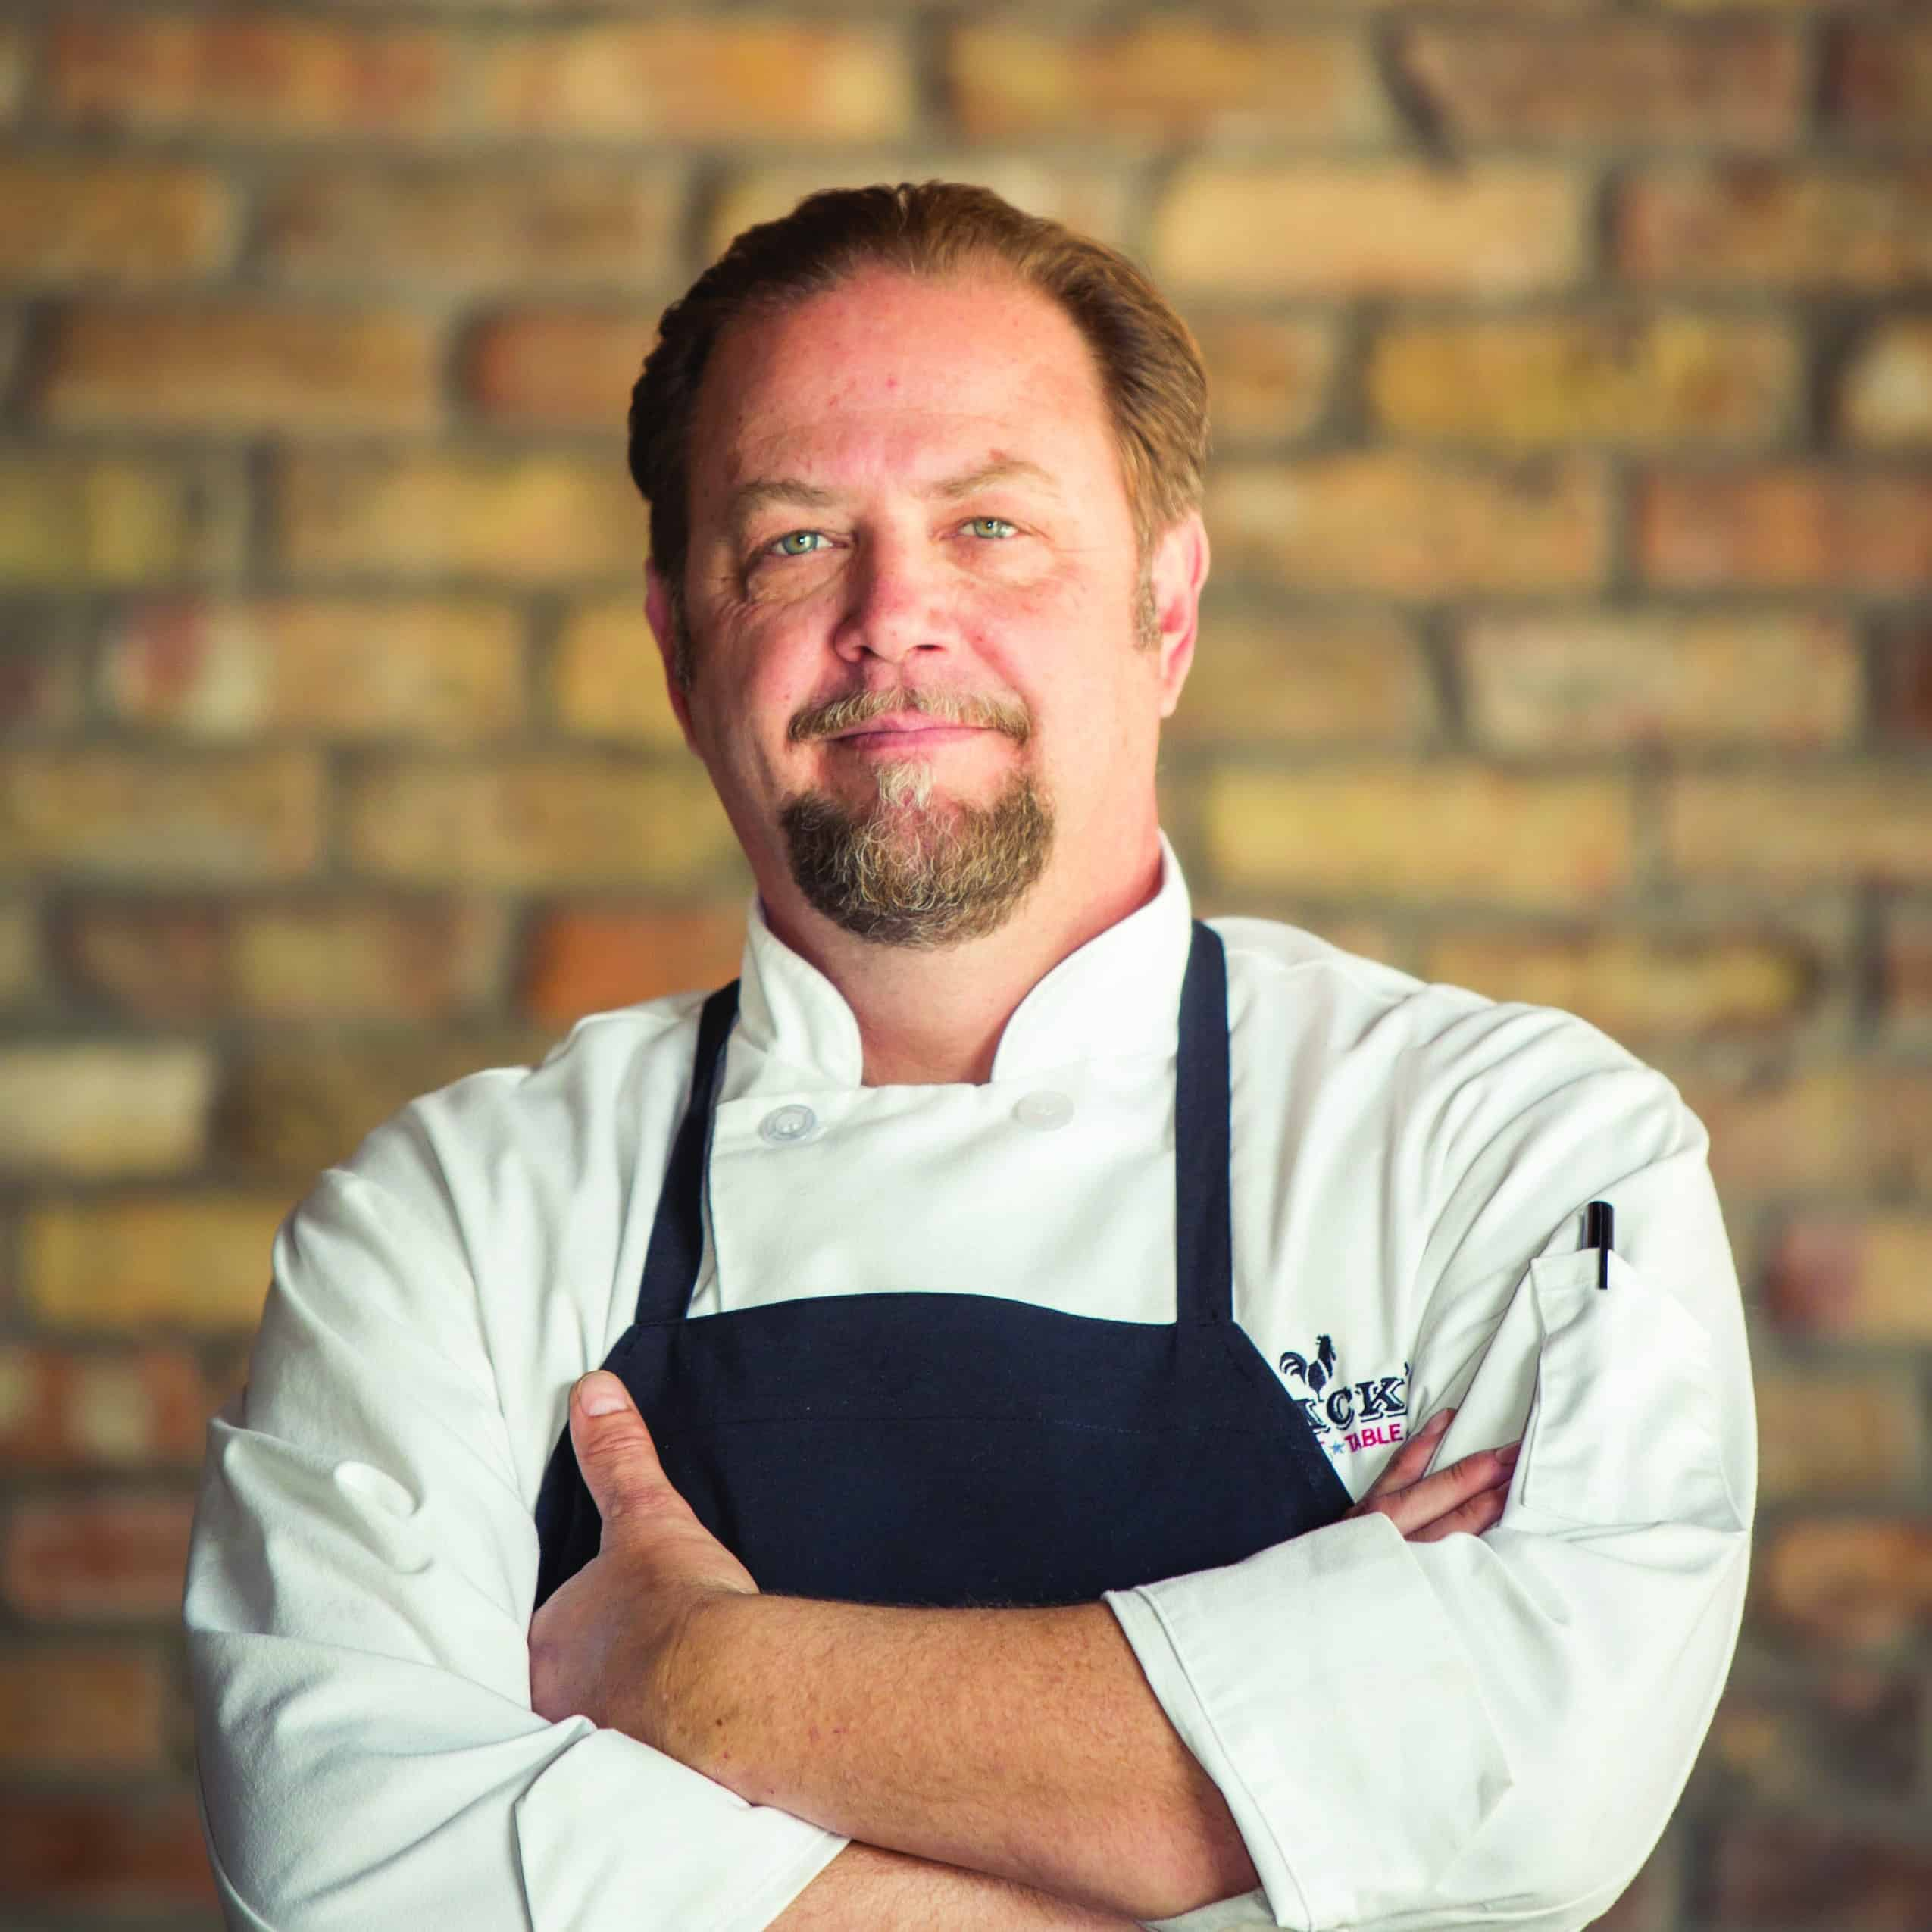

In [24]:
from PIL import Image
from io import BytesIO
from IPython.display import display

conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query profile
username_to_search = 'chef_alex'  # Example

cursor.execute('''
    SELECT * FROM Users
    WHERE username = ?
''', (username_to_search,))

user = cursor.fetchone()

if user:
    user_data = user[:-1]       # everything except the last item
    user_photo = user[-1]       # just the last item (e.g., photo_data)

    print("✅ User found:")
    print("User data (without photo):", user_data)
    image = Image.open(BytesIO(user_photo))
    print("User photo blob (last item):")
    display(image)
else:
    print("❌ User not found.")

conn.close()

In [26]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query 1: Ingredients per Recipe
ingredients_df = pd.read_sql_query('''
    SELECT
        r.name AS recipe_name,
        i.name AS ingredient_name,
        ri.quantity,
        ri.unit
    FROM Recipe r
    JOIN RecipeIngredient ri ON r.id = ri.recipe_id
    JOIN Ingredient i ON i.id = ri.ingredient_id
    ORDER BY r.name, i.name;
''', conn)

print("Ingredients per Recipe:")
display(ingredients_df)

conn.close()

Ingredients per Recipe:


recipe_name ingredient_name quantity    unit
0  Garlic Roasted Veggies          Garlic        4  cloves
1  Garlic Roasted Veggies       Olive Oil       50      ml
2     Tomato Garlic Pasta          Garlic        3  cloves
3     Tomato Garlic Pasta          Tomato        2      kg

In [27]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query 2: Recipes with Authors & Cooking Level
recipes_authors_df = pd.read_sql_query('''
    SELECT
        r.name AS recipe_name,
        u.username,
        u.cooking_level
    FROM Recipe r
    JOIN Users u ON r.user_id = u.user_id;
''', conn)

print("\nRecipes with Authors and Cooking Level:")
display(recipes_authors_df)

conn.close()


Recipes with Authors and Cooking Level:


recipe_name      username  cooking_level
0     Tomato Garlic Pasta  alice_wonder              3
1  Garlic Roasted Veggies   bob_builder              4

In [ ]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query 3: Users' Dietary Preferences (JSON)
dietary_df = pd.read_sql_query('''
    SELECT
        username,
        dietary_preferences
    FROM Users;
''', conn)

print("\nUsers' Dietary Preferences (JSON):")
display(dietary_df)

conn.close()

In [ ]:
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Query 4: Ingredients Used with Allergy Info
allergy_info_df = pd.read_sql_query('''
    SELECT
        u.username,
        r.name AS recipe_name,
        i.name AS ingredient_name,
        u.allergies
    FROM Users u
    JOIN Recipe r ON r.user_id = u.user_id
    JOIN RecipeIngredient ri ON r.id = ri.recipe_id
    JOIN Ingredient i ON i.id = ri.ingredient_id;
''', conn)

print("\nIngredients Used in Recipes with User Allergy Info:")
display(allergy_info_df)

conn.close()

# Closing the database

In [11]:
conn.close()